# Toy example for FG-Pos discrimination

In [2]:
%load_ext autoreload

### Dataset

In [14]:
%autoreload
import datasets

images, labels, n_classes = datasets.dataset_appearance_absolute_position_three_colors()
print(f"{n_classes} classes")
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

4 classes
108 training samples
108 test samples
108 analysis samples


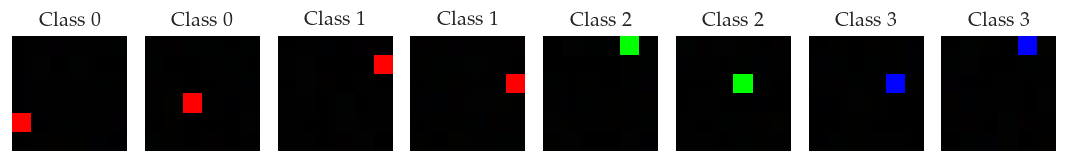

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(1, n_classes * 2, figsize=(1 + n_classes * 2, 2), dpi=120)
j = 0
for c in range(n_classes):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

## Model

In [7]:
%autoreload
from toy_models import TriViTalAbsolutePosition

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


# Training solution

In [16]:
%autoreload
from experiments import run

/home/robert-jan/surfdrive/experiments/vit-position-info/models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


In [22]:
%autoreload

# Train / hybrid
# seeds = range(10)
seeds = [2]
# n_epochs = 4000
n_epochs = 1000
report_every_n = 200
lr = 4e-3
pos_emb = 'absolute'
use_rel_pos = False
weight_decays = [1e-3]
d = 4
n_heads = 2
attribution_method = 'input_gradient_withnegative'
save_raw = 'mixed_position_and_absolute_position_threecolors_{seed}'

for weight_decay in weight_decays:
    print(f"\n\nWeight decay: {weight_decay}")
    run('absolute_position', seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method=attribution_method, weight_decay=weight_decay, save_raw=save_raw)



Weight decay: 0.001
Epoch 0: 1.3839564323425293
Epoch 200: 0.1606859564781189
Epoch 400: 0.0014315013540908694
Epoch 600: 0.0010770692024379969
Epoch 800: 0.0009693059837445617
Epoch 999: 0.0009462825837545097
Accuracy: 1.0
Saved saliency maps to ./toy_saliency_maps/mixed_position_and_absolute_position_threecolors_2_2.pt
Sorting by appearance for these groups of classes:  [range(0, 4)]

Without bias:
appearance (all): 39.58 +- 0.00 (39.58)
appearance (c0) : 3.85 +- 0.00 (3.85)
appearance (c1) : 16.56 +- 0.00 (16.56)
appearance (c2) : 62.15 +- 0.00 (62.15)
appearance (c3) : 88.94 +- 0.00 (88.94)
position (all): 60.42 +- 0.00 (60.42)
position (c0) : 96.15 +- 0.00 (96.15)
position (c1) : 83.44 +- 0.00 (83.44)
position (c2) : 37.85 +- 0.00 (37.85)
position (c3) : 11.06 +- 0.00 (11.06)

With bias:
bias (all): 78.89 +- 0.00 (78.89)
bias (c0) : 90.10 +- 0.00 (90.10)
bias (c1) : 84.76 +- 0.00 (84.76)
bias (c2) : 75.38 +- 0.00 (75.38)
bias (c3) : 57.62 +- 0.00 (57.62)
appearance (all): 11.97 

# Load raw attributions

In [18]:
%autoreload

# import sys
# import os
# sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath('.'))
from analysis import load_raw_attributions


filepath = f"./toy_saliency_maps/mixed_position_and_absolute_position_0.pt"
raw_attributions = load_raw_attributions(filepath)

In [19]:
# Structure of the attributions
print(raw_attributions.keys())
print(raw_attributions['images'].shape)
print(raw_attributions['labels'].shape)
print(raw_attributions['saliency'].keys())
print(len(raw_attributions['saliency']['image']), raw_attributions['saliency']['image'][0].shape)
print(len(raw_attributions['saliency']['image']), raw_attributions['saliency']['bias'][0].shape)
print(len(raw_attributions['saliency']['image']), raw_attributions['saliency']['pos_emb'][0].shape)

dict_keys(['saliency', 'images', 'labels'])
torch.Size([108, 3, 6, 6])
torch.Size([108])
dict_keys(['image', 'bias', 'pos_emb'])
108 torch.Size([3, 6, 6])
108 torch.Size([40])
108 torch.Size([4, 6, 6])


## Visualize

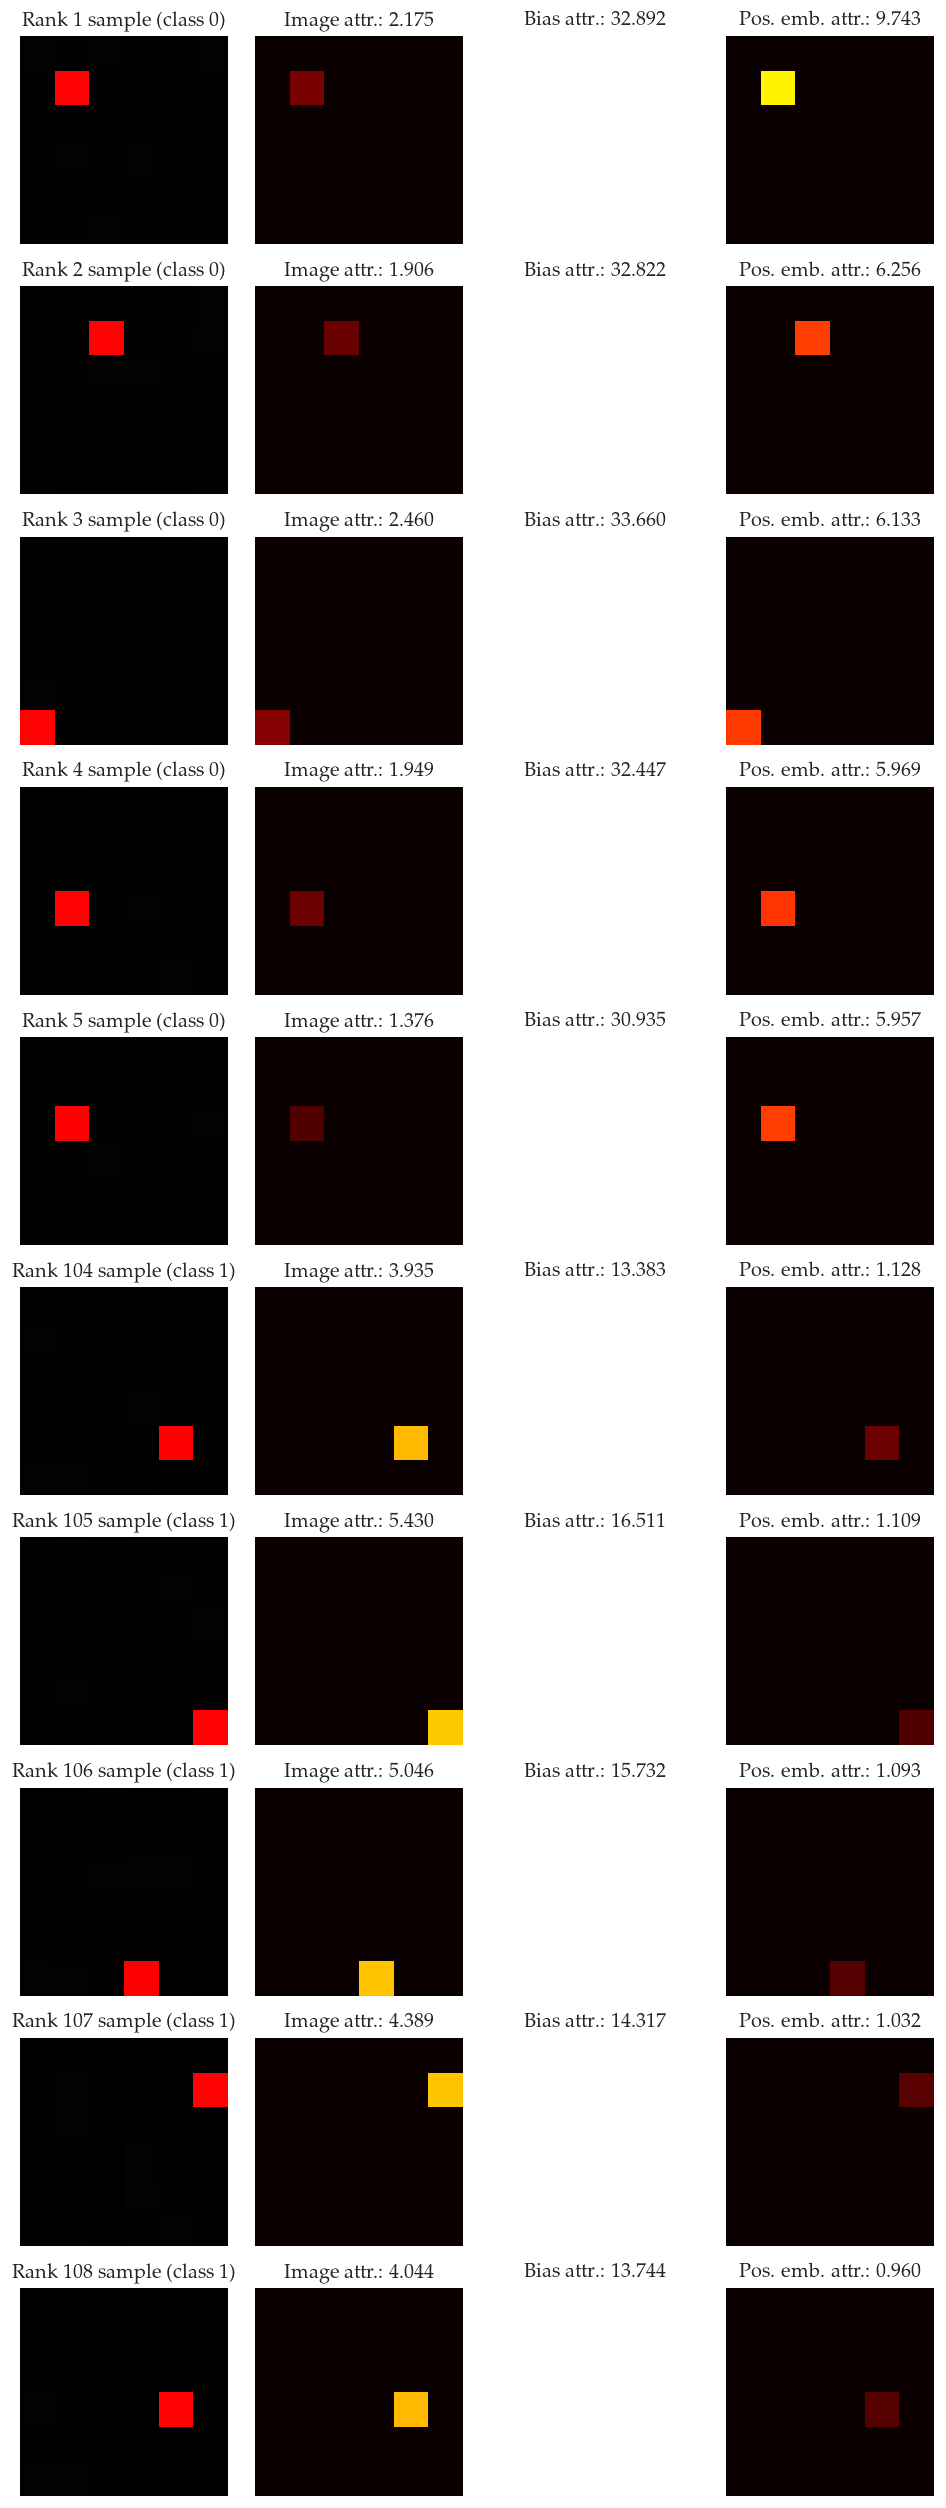

In [20]:
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Sort all entries by the magnitude of the pos_emb saliency map
# Visualize the top n and bottom n
top_n = 5
bot_n = 5

# Plot
# 1) the image with label as caption,
# 2) the image saliency map, divided by the sum of all saliency maps, with the
# bias saliency divided by all saliency maps in the caption,
# 3) the pos_emb saliency map, divided by the sum of all saliency maps

def smap_postprocessing(smap):
    """Default post-processing for FG: abs()"""
    return smap.abs()

n_samples = len(raw_attributions['images'])

ims_mag = torch.zeros(n_samples, dtype=torch.float32)
bias_mag = torch.zeros(n_samples, dtype=torch.float32)
pos_emb_mag = torch.zeros(n_samples, dtype=torch.float32)
index = []
for i in range(n_samples):
    # Compute saliency maps to compute normalization factor
    im_smap = smap_postprocessing(raw_attributions['saliency']['image'][i])
    bias_smap = smap_postprocessing(raw_attributions['saliency']['bias'][i])
    pos_emb_smap = smap_postprocessing(raw_attributions['saliency']['pos_emb'][i])
    # Remove channel/embedding dimension from image and pos_emb saliency map
    im_smap = im_smap.sum(dim=0)
    pos_emb_smap = pos_emb_smap.sum(dim=0)
    # Compute magnitude of each source
    ims_mag[i] = im_smap.sum()
    bias_mag[i] = bias_smap.sum()
    pos_emb_mag[i] = pos_emb_smap.sum()

    index.append((i, ims_mag[i], bias_mag[i], pos_emb_mag[i]))

index = sorted(index, key=lambda x: x[3], reverse=True)
index = [(r+1, i, ims_mag, bias_mag, pos_emb_mag) for r, (i, ims_mag, bias_mag, pos_emb_mag) in enumerate(index)]

#
# Plot
#

fig, axs = plt.subplots(top_n + bot_n, 4, figsize=(2 * 4, 1 + (top_n + bot_n) * 2), dpi=120)
for i, (r, ind, im_mag, bias_mag, pos_emb_mag) in enumerate(index[:top_n] + index[n_samples - bot_n:]):
    # Post-process saliency maps
    im_smap = smap_postprocessing(raw_attributions['saliency']['image'][ind])
    bias_smap = smap_postprocessing(raw_attributions['saliency']['bias'][ind])
    pos_emb_smap = smap_postprocessing(raw_attributions['saliency']['pos_emb'][ind])
    # Remove channel/embedding dimension from image and pos_emb saliency map
    im_smap = im_smap.sum(dim=0)
    pos_emb_smap = pos_emb_smap.sum(dim=0)
    # Compute norm (after computing magnitude): maximum element
    norm = torch.maximum(im_smap.max(), torch.maximum(bias_smap.max(), pos_emb_smap.max()))
    # Apply norm
    im_smap = im_smap / norm
    bias_smap = bias_smap / norm
    pos_emb_smap = pos_emb_smap / norm

    j = 0
    axs[i,j].imshow(raw_attributions['images'][ind].permute((1, 2, 0)), vmin=0., vmax=1.)
    axs[i,j].set_title(f"Rank {r} sample (class {raw_attributions['labels'][ind]})")
    axs[i,j].axis('off')

    j += 1
    axs[i,j].imshow(im_smap, cmap='hot', vmin=0., vmax=1.)
    axs[i,j].set_title(f"Image attr.: {im_mag:.3f}")
    axs[i,j].axis('off')

    j += 1
    # axs[i,j].imshow(im_smap, cmap='hot')
    axs[i,j].set_title(f"Bias attr.: {bias_mag:.3f}")
    axs[i,j].axis('off')

    j += 1
    axs[i,j].imshow(pos_emb_smap, cmap='hot', vmin=0., vmax=1.)
    axs[i,j].set_title(f"Pos. emb. attr.: {pos_emb_mag:.3f}")
    axs[i,j].axis('off')


plt.tight_layout()
pass